## Figure 9

Code to reproduce Figure 9 - Antarctic ozone hole area and SAOD plot

Data used:
- Ozone hole area
    - filenames: *_daily_ozone_area_220DU.nc
- SAOD
    - filenames: *_ssp370_monthly_SAOD.nc

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import ScalarFormatter
import palettable
import cftime
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=16)          # controls default text sizes          
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

## Functions

In [3]:
def calc_oct_mean(df):
    
    df['time']=timestamp
    temp = df.ozone_hole_area[:]/1e6 # from m2 to km2
    october_df = temp.where(temp["time.month"] == 10, drop=True)
    da_oct_mean = october_df.groupby('time.year').mean('time')
    
    return da_oct_mean

def calc_saod(df):
    aitken_soluble = df.m01s02i251[2,:,:,:]
    accum_soluble = df.m01s02i252[2,:,:,:]
    coarse_soluble = df.m01s02i253[2,:,:,:]    
    aitken_insoluble = df.m01s02i254[2,:,:,:]
    
    SAOD_sum = aitken_soluble + accum_soluble + coarse_soluble + aitken_insoluble
   
    weights = np.cos(np.deg2rad(SAOD_sum.latitude))
    weights.name = "weights"
    
    SAOD_sum_weighted = SAOD_sum.weighted(weights)

    SAOD_zonalmean = SAOD_sum_weighted.mean("longitude")

    return SAOD_zonalmean


def plot_eruptions(df, yloc, ax):
    # large eruptions
    selected_data = df
    ax.scatter(selected_data['Year'][selected_data['SO2'] >= 3], 
            np.full(len(selected_data['Year'][selected_data['SO2'] >= 3]), yloc), 
            color = 'black', marker='^', s = 2500,  zorder=20)
  
    # small eruptions
    ax.scatter(selected_data['Year'][(selected_data['SO2'] >= 1) & (selected_data['SO2'] < 3)], 
                np.full(len(selected_data['Year'][(selected_data['SO2'] >= 1) & (selected_data['SO2'] < 3)]), yloc), 
                color = 'grey', marker='^', s = 1000,  zorder=20)
    
    ax.scatter(selected_data['Year'][(selected_data['SO2'] >= 0.1) & (selected_data['SO2'] < 1)], 
                np.full(len(selected_data['Year'][(selected_data['SO2'] >= 0.1) & (selected_data['SO2'] < 1)]), yloc), 
                color = 'lightgrey', marker='^', s = 300,  zorder=20)
    return ax

def plot_area_saod(data_mean, data_max, data_min, da_regr, dn_regr, data_scenario, data_saod, scenario):
    
    daysince = np.arange(2015,2101,1)
    time_regr = np.arange(2015,2071,1)

    ax1.plot(time_regr[:-5], da_regr[:-5], color="navy", lw=1, zorder = 4)
    ax1.plot(time_regr[:-5], dn_regr[:-5], color="red", lw=1, zorder = 4)
    
    ax1.plot(daysince, data_mean, marker = 'o', color = 'navy', label = 'VOLC', lw = 2, ms=1)
    ax1.plot(daysince, ssp370_run['novolc'].mean(dim='ensemble'), marker = 'o', 
             color = 'red', label = 'NOVOLC', lw = 2, ms=1)
    ax1.fill_between(daysince, data_mean, data_max, color = 'lightblue', alpha = 0.3)
    ax1.fill_between(daysince, data_mean, data_min, color = 'lightblue', alpha = 0.3)
    ax1.fill_between(daysince, ssp370_run['novolc'].mean(dim='ensemble'), 
                     ssp370_run['novolc'].max(dim='ensemble'), color = 'pink', alpha = 0.1)
    ax1.fill_between(daysince, ssp370_run['novolc'].mean(dim='ensemble'), 
                     ssp370_run['novolc'].min(dim='ensemble'), color = 'pink', alpha = 0.1)
    
    yloc = -5
    plot_eruptions(data_scenario, yloc, ax1)
    ax1.set_xticklabels([''])
    
    ax2.grid(color='grey', which = 'both', linestyle=':', linewidth=1, alpha = 0.2)
    
    year_axis = np.arange(2015,2100,10)
    
    color = mcolors.LogNorm(0.01, 1000)
        
    daysince = cftime.date2num(data_saod.time, 'days since 2015-01-01', '360_day')
    
    levels1 = np.linspace(0.01,0.5,100)
    sc2 = ax2.contourf(daysince, data_saod.latitude, data_saod.transpose(), levels1, 
                       cmap = 'Blues', extend = 'both', vmax = 0.5, vmin = 0.01)
    
    formatter = ScalarFormatter()
    cbar2 = plt.colorbar(sc2, ticks=[0.01,0.1,0.2,0.3,0.4,0.5], format=formatter, 
                         orientation = "horizontal", fraction = 0.3, pad = 0.3)
    
    cbar2.ax.tick_params(labelsize = 15)
    cbar2.outline.set_visible(True)
    cbar2.set_label('SAOD (550 nm)', fontsize = 15, labelpad = 2)
    
    ax2.set_xlabel('Year', fontsize = 15)
    ax2.set_ylabel('Latitude', fontsize = 15)
    ax2.set_ylim(-90, 90)
    ax2.xaxis.set_major_locator(mdates.YearLocator(10))
    ax2.set_xticklabels(year_axis)
    ax2.set_xlim(0,daysince.max())
    ax1.legend(fontsize = 14, loc = 'upper right', frameon=False)
    
    for ax in (ax1, ax2):
        ax.tick_params(axis='y', labelsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax1.set_ylabel('Area (million km$^2$)', fontsize=15)
        ax1.set_xlim(2015,2100)
        ax1.set_ylim(yloc,25)
        ax.grid(color='grey', which = 'both', linestyle='dotted', linewidth=1, alpha = 0.2)
    
    ax1.set_title(scenario, fontsize=16, loc = 'left')

    return

## Read files

In [36]:
ozone_thres = '220DU'
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/\
Ozone_processed/antarctic_ozone_hole/ozone_hole_'+ozone_thres+'/')

ssp370_run = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc50_1s': volc50_1s,
              'volc50_2s': volc50_2s,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_run:
    
    df = xr.open_dataset(idx+'_daily_ozone_area_220DU.nc')       
    ssp370_run[idx] = df

In [29]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/SAOD_monthly/')

ssp370_saod = {'novolc': novolc,
              'volc50': volc50_1,
              'volc50_2': volc50_2,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_saod:

    df = xr.open_dataset(idx+'_ssp370_monthly_SAOD.nc')
       
    ssp370_saod[idx] = df.monthly_saod.mean(dim=['longitude','ensemble'])

In [19]:
path = '/home/users/mmc70/Notebooks/GRL_notebooks/GRL_data_repository/'

df_volc25 = pd.read_csv(path+'stochastic_volc2_5.csv')
df_volc50_1 = pd.read_csv(path+'stochastic_volc50_1.csv')
df_volc50_2 = pd.read_csv(path+'stochastic_volc50_2.csv')
df_volc98 = pd.read_csv(path+'stochastic_volc98.csv')

In [20]:
def func_linreg_mean(data, start_year, end_year):

    year1, data1 = get_x_intercept(data[0], start_year, end_year)
    year2, data2 = get_x_intercept(data[1], start_year, end_year)
    year3, data3 = get_x_intercept(data[2], start_year, end_year)

    mean_year = (year1 + year2 + year3) / 3
    mean_data = (data1 + data2 + data3) / 3


    print('Mean: ', round(mean_year))

    return mean_data

def get_x_intercept(data, start_year, end_year):

    year = np.arange(start_year,end_year+1,1).reshape((-1,1))
    data1 = np.array(data.where((data['year'] >= start_year) & (data['year'] <= end_year), drop=True))

    # get regression line
    model2 = LinearRegression().fit(year, data1)
    year_test = np.arange(start_year,end_year+1,1).reshape((-1,1))
    data_plot = model2.predict(year_test)

    # get x-intercept
    year2 = np.arange(start_year,end_year+1,1)
    data2 = np.array(data.where((data['year'] >= start_year) & (data['year'] <= end_year), drop=True)).reshape((-1,1))
    model = LinearRegression().fit(data2, year2)
    print(f"intercept: {round(model.intercept_)}")
    #print(f"slope: {model.coef_[0]}")

    return round(model.intercept_), data_plot

start_year = 2015
end_year = 2070

print('volc25')
volc25_regr = func_linreg_mean(ssp370_run['volc25'], start_year, end_year)

print('\n')
print('volc50_1')
volc50_1_regr = func_linreg_mean(ssp370_run['volc50_1'], start_year, end_year)

print('\n')
print('volc50_1s')
volc50_1s_regr = func_linreg_mean(ssp370_run['volc50_1s'], start_year, end_year)


print('\n')
print('volc50_2')
volc50_2_regr = func_linreg_mean(ssp370_run['volc50_2'], start_year, end_year)

print('\n')
print('volc50_2s')
volc50_2s_regr = func_linreg_mean(ssp370_run['volc50_2s'], start_year, end_year)


print('\n')
print('volc98')
volc98_regr = func_linreg_mean(ssp370_run['volc98'], start_year, end_year)

print('\n')
print('novolc')
novolc_regr = func_linreg_mean(ssp370_run['novolc'], start_year, end_year)


volc25
intercept: 2056
intercept: 2060
intercept: 2059
Mean:  2058


volc50_1
intercept: 2060
intercept: 2060
intercept: 2058
Mean:  2059


volc50_1s
intercept: 2060
intercept: 2059
intercept: 2059
Mean:  2059


volc50_2
intercept: 2058
intercept: 2059
intercept: 2060
Mean:  2059


volc50_2s
intercept: 2058
intercept: 2059
intercept: 2059
Mean:  2059


volc98
intercept: 2062
intercept: 2060
intercept: 2061
Mean:  2061


novolc
intercept: 2058
intercept: 2058
intercept: 2059
Mean:  2058


/tmp/ipykernel_12325/2063453832.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_12325/2063453832.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'a')

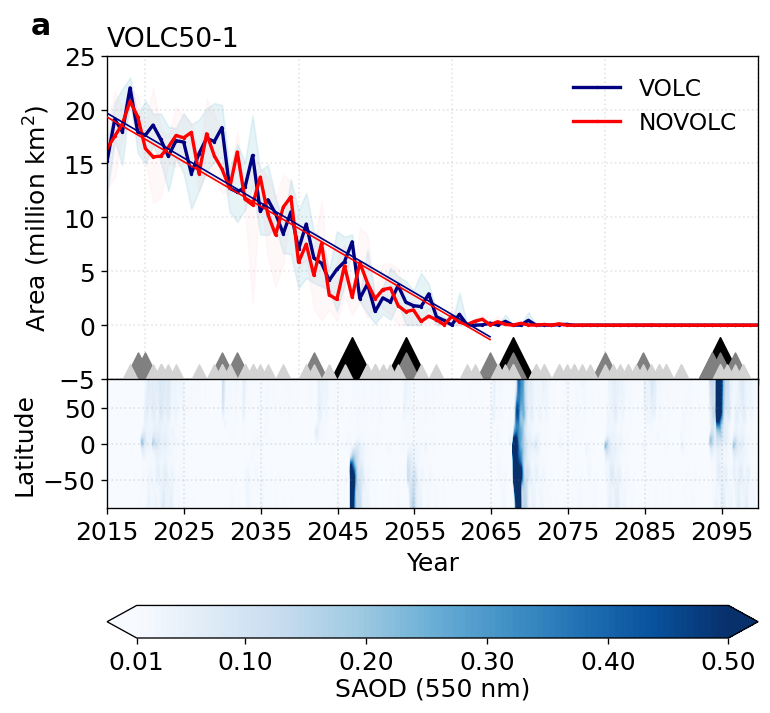

In [31]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc50_1'].mean(dim='ensemble'), 
               ssp370_run['volc50_1'].max(dim='ensemble'),
               ssp370_run['volc50_1'].min(dim='ensemble'), 
               volc50_1_regr, novolc_regr,
               df_volc50_1, ssp370_saod['volc50'], 'VOLC50-1')

ax1.text(2005, 27, 'a', weight = 'bold', fontsize = 18)

/tmp/ipykernel_12325/2063453832.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_12325/2063453832.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'b')

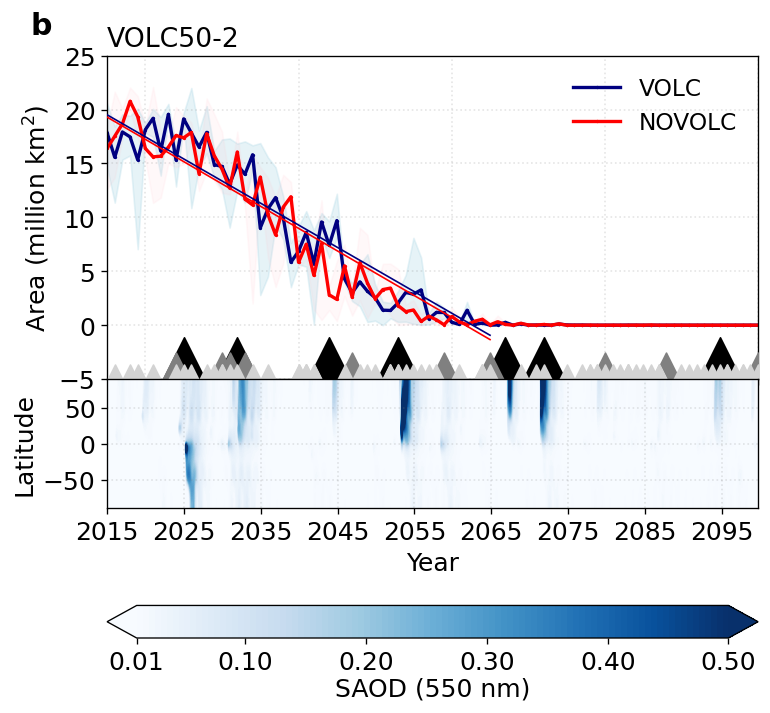

In [32]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc50_2'].mean(dim='ensemble'), 
               ssp370_run['volc50_2'].max(dim='ensemble'),
               ssp370_run['volc50_2'].min(dim='ensemble'), 
               volc50_2_regr, novolc_regr,
               df_volc50_2, ssp370_saod['volc50_2'], 'VOLC50-2')

ax1.text(2005, 27, 'b', weight = 'bold', fontsize = 18)

/tmp/ipykernel_12325/2063453832.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_12325/2063453832.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'c')

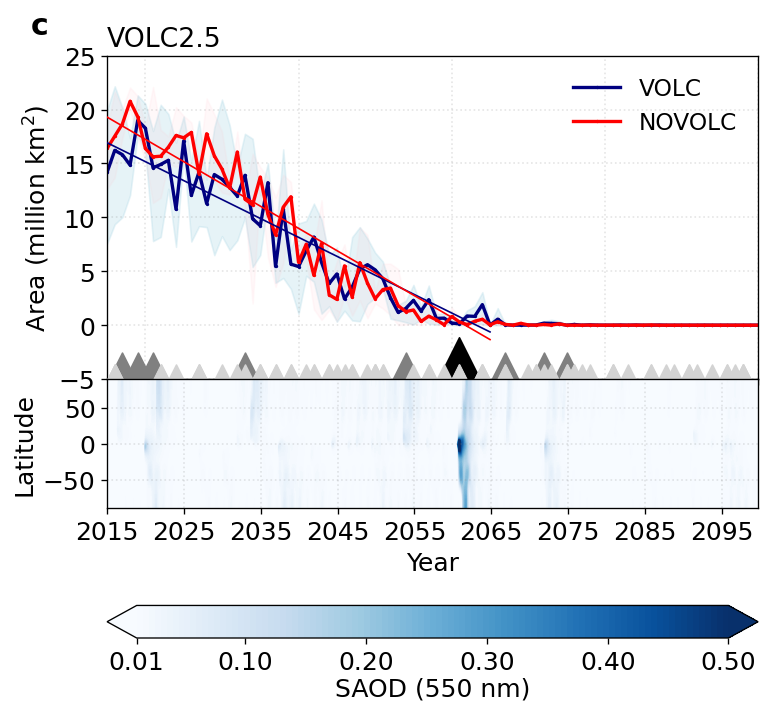

In [33]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc25'].mean(dim='ensemble'), 
               ssp370_run['volc25'].max(dim='ensemble'),
               ssp370_run['volc25'].min(dim='ensemble'),
               volc25_regr, novolc_regr,
               df_volc25, ssp370_saod['volc25'], 'VOLC2.5')

ax1.text(2005, 27, 'c', weight = 'bold', fontsize = 18)

/tmp/ipykernel_12325/2063453832.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_12325/2063453832.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'd')

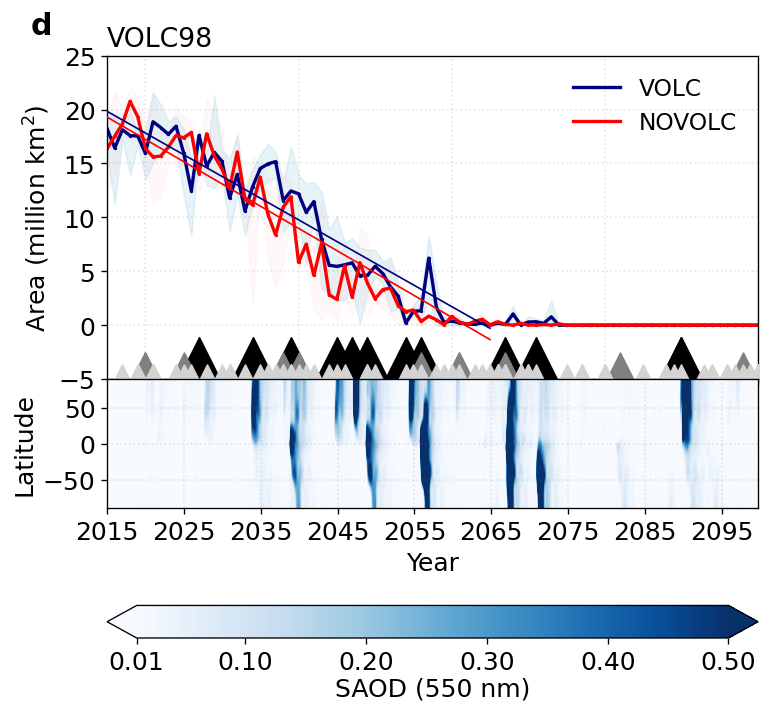

In [35]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc98'].mean(dim='ensemble'), 
               ssp370_run['volc98'].max(dim='ensemble'),
               ssp370_run['volc98'].min(dim='ensemble'), 
               volc98_regr, novolc_regr,
               df_volc98, ssp370_saod['volc98'], 'VOLC98')

ax1.text(2005, 27, 'd', weight = 'bold', fontsize = 18)